# The causal data science pipeline in practice
<!-- Demo using example of a retail problem. -->

Let's say retailer offers a premium monthly subscription programme: 
* further discounts on mainline shopping, and
* benefits with this company's other verticals (e.g. clothing line; cafe; etc). 

Question: **What is the effect of subscribing to this programme on mainline spend at this company?**  
* Synthetic data




# The causal pipeline

## 1. Draw causal DAG
First, map out the relevant variables
* **X: subscribing or not**
* **Y: spend**
* Other relevant causes? Sit down and think with team and stakeholders, think of all potential causes and causal paths that could affect whether subscribe and/or spend?
    - **disposable income:** high income might spend more and not care about discounts/ benefits of the programme
    - **age:** depending on age, different needs, life stages, mindsets, e.g. 20s, 40s, 70s.
    - **family size:** if someone with a large family, higher volume of shopping, might spend more, and might see value in subscribing and discounts etc benefits
    - **interest in verticals:** if are interested other verticals, might find programme more appealing.
    - **... more:** realistically will have many more relevant, but stop here in the interest of time.

Draw all this in causal DAG as you go, with all possible arrows, and visualise it. 

Python [DoWhy](https://github.com/py-why/dowhyhttps://github.com/py-why/dowhy) syntax:


In [2]:
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel

In [3]:
dowhy.__version__ # not latest: Date: Sep 05, 2023 Version: v0.10.1

'0.8'

In [4]:
# Digraph Syntax

causal_graph = """
digraph {
age -> disp_income; age -> vertical_interest; age -> family_size;
age -> premium_sub; age -> post_spend; 
disp_income -> vertical_interest; disp_income -> family_size;
disp_income -> premium_sub; disp_income -> post_spend;
family_size -> vertical_interest; family_size -> premium_sub;
family_size -> post_spend;
vertical_interest-> premium_sub; vertical_interest-> post_spend;
premium_sub -> post_spend;
}
"""

To define a `CausalModel` object in DoWhy and then identify estimands, first need a dataframe with columns : DAG variables, no need for data

In [5]:
import pandas as pd

In [6]:
df_model = pd.DataFrame(columns=['age', 'disp_income', 'family_size', 'premium_sub', 
                                 'post_spend', 'vertical_interest'])
df_model.head()

,age,disp_income,family_size,premium_sub,post_spend,vertical_interest


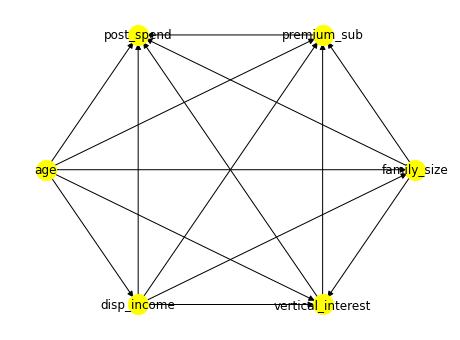

In [7]:
# Define a CausalModel object in DoWhy, indicate treatment & outcome
model= CausalModel(data=df_model, # data columns
        graph=causal_graph, # DAG
        treatment='premium_sub', # cause of interest, X
        outcome='post_spend') # outcome, Y
model.view_model()

Other ways to visualise DAG:
 * networkX Python library
 * [DAGitty](https://www.dagitty.net/dags.html#) interactive web tool
 
 

**We now have the DAG, can run identification on it to see what should adjust for.**

# 2. Identification

In [8]:
# Identify the causal effect

estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
──────────────(Expectation(post_spend|vertical_interest,disp_income,family_siz
d[premium_sub]                                                                

       
e,age))
       
Estimand assumption 1, Unconfoundedness: If U→{premium_sub} and U→post_spend then P(post_spend|premium_sub,vertical_interest,disp_income,family_size,age,U) = P(post_spend|premium_sub,vertical_interest,disp_income,family_size,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



**We now know what variables we should adjust for, can proceed to estimation.**

# Before estimation: The data

Having drawn out our view of how the world works (the DAG), and figured out via identification the available estimands (backdoor here), and what we should adjust for, we now look at our data to see whether it contains good measures for all variables in our minimal adjustment set. Construct valilidity, operationalisation.

Having inspected our data, let's say we find it does contain adequate-looking measures (or proxies) for all variables in the minimal deconfounding set*:
* **disposable income**: a binary **`affluence`** segementation
* **family size**: number of children under the age of 18 at that househould, **`num_child_u18`**
* **interest in vericals**: **`vertical_frac`**, % of previous spend on verticals -- being an existing customer may indicate continued interest in the future, in proportion to previous spend
* **age**: measured in years in column **`age`**

(* If a dataset does _not_ contain good measures for all varaibles in the min. deconfounding set: the causal effect of interest is _not identifiable_ based on this data. Cannot make causal claims, as cannot remove confounding. So either try to get data on unobserved variables/ do not make causal claims/ try sensitivity analysis to bound size of remaining bias from these unmeasured confounders, requires extra assumptions -- more in the validation/refutation section below)

The data also contains these columns for X and Y:
- **X** measured in **`premium_sub`:**  1 for customers who join the premium subscription, 0 for those who don't 
- **Y** measured in **`post_spend`:** aggregate spend (in £) in the 12 months after the window of opportunity to subscribe to the scheme or not, for each given window.

We now load & inspect our data:
* Columns for the above causal variables. 
* One row per household -- max 1 subscription possible per household:

In [9]:
import pandas as pd
df = pd.read_csv('full_data.csv')
df.head()

,age,affluence,num_child_u18,vertical_frac,post_spend,premium_sub
0,31,1,1,0.11,1723.96,0
1,76,0,0,0.02,2144.16,0
2,50,0,1,0.15,457.00,0
3,42,0,5,0.05,7373.70,0
4,48,1,6,0.11,742.11,1


Now, make variable measure names in dataset match variable names in the DAG -- `CausalModel`'s `graph` parameter, replace variable names by their measure names:

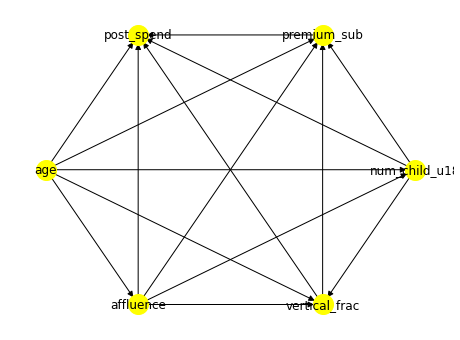

In [10]:
# Identify the causal effect

# Digraph Syntax
causal_graph = """
digraph {
age -> affluence; age -> vertical_frac; age -> num_child_u18;
age -> premium_sub; age -> post_spend;
affluence -> vertical_frac; affluence -> num_child_u18;
affluence -> premium_sub; affluence -> post_spend;
num_child_u18 -> vertical_frac; num_child_u18 -> premium_sub;
num_child_u18 -> post_spend;
vertical_frac -> premium_sub; vertical_frac -> post_spend;
premium_sub -> post_spend;
}
"""
model= CausalModel(data=df, # actual dataset now
        graph=causal_graph,
        treatment='premium_sub',
        outcome='post_spend')
model.view_model()


In [11]:
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
──────────────(Expectation(post_spend|num_child_u18,affluence,age,vertical_fra
d[premium_sub]                                                                

   
c))
   
Estimand assumption 1, Unconfoundedness: If U→{premium_sub} and U→post_spend then P(post_spend|premium_sub,num_child_u18,affluence,age,vertical_frac,U) = P(post_spend|premium_sub,num_child_u18,affluence,age,vertical_frac)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



**Now that we've found adequate measures in our data for all variables in the minimal deconfounding set, and used this data of these measures in our DAG and identification step, we can do estimation.**

# 3. Estimation
DoWhy implements some estimation methods:

In [12]:
estimate = model.estimate_effect(estimands,
                                 method_name="backdoor.linear_regression",
                                 effect_modifiers= [],
                                 confidence_intervals=True,
                                 test_significance=True)
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
──────────────(Expectation(post_spend|num_child_u18,affluence,age,vertical_fra
d[premium_sub]                                                                

   
c))
   
Estimand assumption 1, Unconfoundedness: If U→{premium_sub} and U→post_spend then P(post_spend|premium_sub,num_child_u18,affluence,age,vertical_frac,U) = P(post_spend|premium_sub,num_child_u18,affluence,age,vertical_frac)

## Realized estimand
b: post_spend~premium_sub+num_child_u18+affluence+age+vertical_frac
Target units: ate

## Estimate
Mean value: 555.9003475909958
p-value: [2.60024816e-29]
95.0% c

In [13]:
estimate.interpret()

Increasing the treatment variable(s) [premium_sub] from 0 to 1 causes an increase of 555.9003475909958 in the expected value of the outcome [post_spend], over the data distribution/population represented by the dataset.


So joining this premium subscription programme has a causal effect of spending £555.9 more at this retailer over the next 12 months. (Synthetic data)

### Standard Python libraries also apply for estimation
Can use statsmodels, or sklearn (tree-based, with partial dependence plots for coefficients equivalents).

E.g. statsmodels OLS. We get the exact same results as with the DoWhy OLS estimation.

In [14]:
import statsmodels.formula.api as smf

In [15]:
reg_model_all = smf.ols(formula='post_spend ~ premium_sub + vertical_frac + age + affluence + num_child_u18', data = df)
ols_all = reg_model_all.fit()
print('Effect of premium sub: \n coeff: \t', ols_all.params['premium_sub'], 
      '\n p value: \t', ols_all.pvalues.loc['premium_sub'], 
     '\n 95% C.I.s: \t', ols_all.conf_int(alpha = 0.05).loc['premium_sub'].values)

Effect of premium sub: 
 coeff: 	 555.9003475909925 
 p value: 	 2.6002481581378363e-29 
 95% C.I.s: 	 [459.14064275 652.66005243]


## *Confounding bias, Simpson's paradox*

In this case, we had to control for everything.  *Not* a general rule:
* must not control for colliders, bias (more below); 
* computationally inefficient to control for confounders not in the minimal set


E.g. if we don't have data for some/ all of the varablies in the minimal deconfounding set, cannot adjust for them in the estimation model. Some confounding bias will remain, effect not guaranteed to be the same or close to the unbiased one. 

#### Some scenarios:

#### *a. Unobserved: all confounders*

In [16]:
# Unadjusted estimate is confounded
reg_model = smf.ols(formula='post_spend ~ premium_sub', data = df)
ols = reg_model.fit()
print(ols.params["premium_sub"])

1097.9085781224944


Estimate way off, overestimates effect by almost 2x -- confounding bias is very large.

#### *b. Unobserved: age, num_child_u18*

In [17]:
reg_model_some = smf.ols(formula='post_spend ~ premium_sub + vertical_frac + affluence', data = df)
ols_some = reg_model_some.fit()

print('Effect of premium sub: \n coeff: \t', ols_some.params['premium_sub'], 
      '\n p value: \t', ols_some.pvalues.loc['premium_sub'], 
     '\n 95% C.I.s: \t', ols_some.conf_int(alpha = 0.05).loc['premium_sub'].values)

Effect of premium sub: 
 coeff: 	 642.2524825036953 
 p value: 	 1.5286533516181535e-39 
 95% C.I.s: 	 [546.82690115 737.67806386]


Estimate is off again, now by a factor of 1.15.

#### *c. Unobserved: age, num_child_u18, __& affluence__*

In [18]:
reg_model_some2 = smf.ols(formula='post_spend ~ premium_sub + vertical_frac', data = df)
ols_some2 = reg_model_some2.fit()

print('Effect of premium sub: \n coeff: \t', ols_some2.params['premium_sub'], 
      '\n p value: \t', ols_some2.pvalues.loc['premium_sub'], 
     '\n 95% C.I.s: \t', ols_some2.conf_int(alpha = 0.05).loc['premium_sub'].values)


Effect of premium sub: 
 coeff: 	 1097.9103163047 
 p value: 	 6.418127339061289e-168 
 95% C.I.s: 	 [1020.87911911 1174.9415135 ]


Estimate is way off again, again by almost a factor of 2.

## *Collider bias, Berkson's paradox*
* The case against throwing all variables as inputs into the model.
* Same DAG.
* Now want the effect of *age* on spend, and we still have data on the other variables.
* Now: no confounders, no arrows into age, no common causes possible between it and spend.  Thus, regressing `post_spend` only on `age` would give the correct causal estimate.

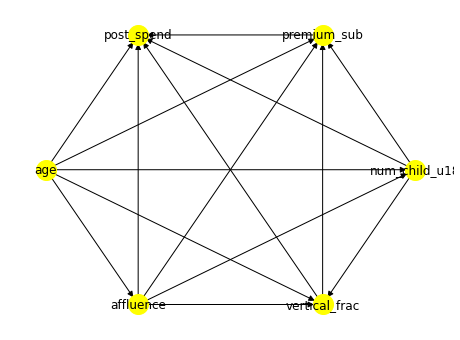

In [20]:
model_age= CausalModel(data=df,
        graph=causal_graph,
        treatment='age',# different X now
        outcome='post_spend')
model_age.view_model()


In [21]:
# 2. Identify
estimands_age = model_age.identify_effect()
# 3. Estimate
estimate_age = model_age.estimate_effect(estimands_age,
                                 method_name="backdoor.linear_regression",
                                 confidence_intervals=True,
                                 test_significance=True)
print(estimate_age)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                            
──────(Expectation(post_spend))
d[age]                         
Estimand assumption 1, Unconfoundedness: If U→{age} and U→post_spend then P(post_spend|age,,U) = P(post_spend|age,)

## Realized estimand
b: post_spend~age
Target units: ate

## Estimate
Mean value: 16.514473672870963
p-value: [4.48957132e-85]
95.0% confidence interval: [[14.86778215 18.1611652 ]]



What if we adjust for some of the other variables? 

DAG shows there are 3 colliders: `premium_sub`, `vertical_frac`, and `num_child_u18` are colliders on the paths between `age` and `post_spend`. 
e.g.  
* `num_child_u18` is a collider on the path: `age` --> `num_child_u18` <-- `affluence` --> `post_spend`
* `vertical_frac` is a collider on the path: `age` --> `vertical_frac` <-- `num_child_u18` --> `post_spend`


If we adjust for any, or all, of them, we will introduce collider bias into the estimate. 
For example, 

#### *a. Erroneously adjust for ALL colliders*

In [22]:
# ATE OF AGE on SPEND - erroneously adjust for ALL others, colliders
reg_age2 = smf.ols(formula='post_spend ~ age + premium_sub + vertical_frac + num_child_u18 ', data = df)
ols_age2 = reg_age2.fit()
print('Effect of age: \n coeff: \t', ols_age2.params['age'], 
      '\n p value: \t', ols_age2.pvalues.loc['age'], 
     '\n 95% C.I.s: \t', ols_age2.conf_int(alpha = 0.05).loc['age'].values)

Effect of age: 
 coeff: 	 13.523374963177083 
 p value: 	 7.789530825371502e-48 
 95% C.I.s: 	 [11.70485859 15.34189134]


Substantially different, biased, estimate -- 18% lower than the correct estimate of 16.5.

#### *b. Erroneously adjust for SOME colliders: unobserved num_child_u18*
Assume the `num_child_u18` collider is unmeasured, adjust for all others which are measured.

In [23]:
# ATE OF AGE on SPEND - erroneously adjust for ALL others, colliders
reg_age3 = smf.ols(formula='post_spend ~ age + premium_sub + vertical_frac ', data = df)
ols_age3 = reg_age3.fit()
print('Effect of age: \n coeff: \t', ols_age3.params['age'], 
      '\n p value: \t', ols_age3.pvalues.loc['age'], 
     '\n 95% C.I.s: \t', ols_age3.conf_int(alpha = 0.05).loc['age'].values)

Effect of age: 
 coeff: 	 11.13673765674627 
 p value: 	 3.3131038736435847e-38 
 95% C.I.s: 	 [ 9.45186578 12.82160953]


Biased estimate now 32.5% lower than the correct one.

So, naively using all/ as many as possible variables as inputs can result in very substantial bias! Don't throw in everything and the kitchen sink.

**Overall, confounding bias (Simpson's paradox) and/or collider bias (Berkson's paradox) can lead to highly biased estimates.**

-- 

Going back to our original, correctly identified, unbiased estimate:

**We've found that joining this subscription programme causes additional future spending of £555.9 on average at this retailer over the next year. (Synthetic data).**

**Now we can proceed to validation, to check whether our DAG, and our whole estimate, are consistent with our data.**

# 4. Validation

## 4.A. DAG vs. data

DAG - d-separation - (conditional) dependecies & independencies. Must
1. **DAG**: apply d-separation, find what (conditional) independecies the DAG implies, if any.
2. **vs. data**: test if these (conditional) independecies all also exist in the data, standard statstistical tests.

### Both, in DoWhy
DoWhy `refute_graph()` tests whether **X ⊥ Y | Z**, for all possible combinations of X, Y and Z. 

Z is a set, parameter `k` below is the number of variables in it. So k max can be (num DAG variables - 2).

In [24]:
# DoWhy
for k in list(range(0,5)):
    print(f'k={k}')
    refuter_object = model.refute_graph(k=k, 
                                    independence_test = {'test_for_continuous': 'partial_correlation', 
                                                         'test_for_discrete' : 'conditional_mutual_information'}) #Change k parameter to test conditional independence given different number of variables 
    print(refuter_object)

k=0
Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:0
Number of independences satisfied by data:0
Test passed:True

k=1
Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:0
Number of independences satisfied by data:0
Test passed:True

k=2
Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:0
Number of independences satisfied by data:0
Test passed:True

k=3
Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:0
Number of independences satisfied by data:0
Test passed:True

k=4
Method name for discrete data:conditional_mutual_inf

This specific DAG implies: only (conditional) dependencies, no independence claims -- nothing is d-separable from anything. So this DAG makes no strong claims of independence.


### DAG: in DAGitty...
* If you'd like to see _which_ (conditional) independencies the DAG implies, DAGitty lists all. But can't load data into DAGitty web tool, so then ... 

### ... vs. the data: in DoWhy
* Use DoWhy to test each of these against the data. (If any of these fail vs. the data, we will know _which part_ of the DAG is wrong and so we should revisit.) 


Normally we'd only check the **in**dependence relationships found, but here there's none -- still, functionality shown below. 

DoWhy's Partial correlation implementation, tests whether X and Y are independent (uncorrelated) conditional on Z:

In [25]:
from dowhy.utils.cit import partial_corr

partial_corr(df, x='vertical_frac', y='post_spend', z=['affluence'])

{'n': 16796,
 'r': 0.042714942805828805,
 'CI95%': [array([0.028, 0.058])],
 'p-val': 0.0}

In [26]:
partial_corr(df, x='affluence', y='post_spend', z=[])

{'n': 16796,
 'r': 0.21598236165125034,
 'CI95%': [array([0.202, 0.23 ])],
 'p-val': 0.0}

Interpreting this output:
* `n`: the number of rows in our data
* `r`: the partial correlation coefficient between x and y, conditional on z. If z=[], empty set, unconditional independence test. Here: Non-0 correlation coefficients.
* `CI95%`: the 95% confidence interval for `r`.
* `p-val`: the p-value at the 5% significance level. If this is less than 0.05, we can reject the null hypothesis that x and y are independent conditional on z. Here, the p-value is 0.0 < 0.05, which means there is a stastistically significant dependence i.e. correlation.


**So, we've found that our DAG is consistent with our data.**

## 4.B DoWhy: Final estimate vs. data
Estimate obtained from chosen estimation model (with inputs chosen based on 1. DAG; 2. identificaiton step) vs the data.

DoWhy offers several refuters for this.

E.g. these 3 refuters, per the DoWhy documentation:

* Does the estimated effect change significantly when we replace the given dataset with ...
   -  ... bootstrapped samples from the same dataset? (**Bootstrap Validation**)
   - ...  a randomly selected subset? (**Data Subsets Validation**)
* Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (**Add Random Common Cause**)

For all 3 - Hint: It should not.


For these tests to indicate that our results are valid, in their outputs they should all:
   * Give an 'Estimated Effect' that is close to the 'New Effect' (that they compute under these changes), &
   * Give a large p-value, greater than 0.05, meaning: no statistically significant difference between the estimated and the new effects
 

In [27]:
# Refute estimate
refutation_list= []
inspect_refutations = True
refuter_list = ["bootstrap_refuter", "data_subset_refuter", "random_common_cause"]

In [28]:
%%capture
for refuter in refuter_list:
    ref = model.refute_estimate(estimands, estimate, method_name=refuter)
    refutation_list.append(ref)

In [29]:
# Refutation values
refuter_count = 1
if inspect_refutations is True:
    for refutation in refutation_list:
        print("####### Refutation {}#######################################################################################".format(refuter_count))
        print(refutation)
        refuter_count += 1

####### Refutation 1#######################################################################################
Refute: Bootstrap Sample Dataset
Estimated effect:555.9003475909958
New effect:553.3173718006659
p value:1.0

####### Refutation 2#######################################################################################
Refute: Use a subset of data
Estimated effect:555.9003475909958
New effect:552.3741440620961
p value:0.8400000000000001

####### Refutation 3#######################################################################################
Refute: Add a random common cause
Estimated effect:555.9003475909958
New effect:555.9663141143694
p value:0.92



As expected, all 3 refuters find: our estimate is consistent with the data. There is no statistically significant difference between the estimated and the new effects (New and Estimated effect values: very similar; p-values are greater than 0.05). 


DoWhy has further refuters. Note: one for **sensitivity analysis** to unmeasured confounders (`method_name="add_unobserved_common_cause"`):
* How much will the effect estimate change, at different levels of unmeasured confounding? E.g. will it still be positive? 
* This requires the user to parametrise it with assumptions for the maximum possible effect size of an unmeasured confounder, based on domain expertise. 
* For more, see this example notebook: https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/dowhy_simple_example.ipynb

### DAGitty online tool

https://dagitty.net/dags.html#

e.g. click 'Examples' at the top, select 'Extended Confouding Triangle'.


# Further materials
If you'd like to understand more about these tools, resources to check out next:
* DoWhy - user guide: https://www.pywhy.org/dowhy/v0.10.1/user_guide/index.html
* DAGitty.net - brief 'cheat sheet' guide: https://dagitty.net/learn/primer/Dagitty-Cheat-Sheet.pdf 